# 1.9d: Raw Bit Separations (13 black holes)

From 1.9c we know the 13 black holes are separated by 32, 64, or 128 ULP in different dimensions.

**Question:** In terms of **representable numbers**, how far apart are they?

Since bfloat16 is stored as uint16, we can:
1. Convert each BH vector to uint16 (raw bits)
2. Compute `|BH_i - BH_j|` in uint16 space
3. That number = exactly how many representable numbers apart they are

This is like 1.8g but for the **true 13 black holes** instead of 4 merged ones.

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Active dimensions from 1.9c
ACTIVE_DIMS = [216, 282, 322, 450, 993, 1008, 1149, 1155, 1272, 1382, 
               1403, 1435, 1487, 1564, 1763, 2012, 2040, 2079, 2143, 2479]

## Imports

In [2]:
import torch
import ml_dtypes
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from itertools import combinations

## Helper Functions

In [3]:
def decode_bfloat16_bits(value_bf16):
    """Decode a bfloat16 value into its bit components."""
    bits_uint16 = np.frombuffer(value_bf16.tobytes(), dtype=np.uint16)[0]
    bits_binary = format(bits_uint16, '016b')
    
    sign_bit = bits_binary[0]
    exponent_bits = bits_binary[1:9]
    mantissa_bits = bits_binary[9:16]
    
    sign = int(sign_bit)
    exponent = int(exponent_bits, 2)
    mantissa = int(mantissa_bits, 2)
    
    return {
        'bits_uint16': bits_uint16,
        'bits_binary': bits_binary,
        'sign': sign,
        'exponent': exponent,
        'mantissa': mantissa,
        'sign_bit': sign_bit,
        'exponent_bits': exponent_bits,
        'mantissa_bits': mantissa_bits
    }

## Load Data

In [4]:
# Load W in bfloat16
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]

print(f"Loaded W: {W_bf16.shape}")
print(f"Dtype: {W_bf16.dtype}")

Loaded W: torch.Size([151936, 2560])
Dtype: torch.bfloat16


In [5]:
# Load corrected core data from 1.9b
core_path = Path(f"../tensors/{MODEL_NAME}/1.9b_core_bfloat16.safetensors")
core_data = load_file(core_path)

core_token_ids = core_data["core_token_ids"].to(torch.int64)
bh_labels = core_data["bh_labels"].to(torch.int64)
n_black_holes = core_data["n_black_holes"].item()

print(f"\nLoaded core data: {n_black_holes} black holes")


Loaded core data: 13 black holes


## Extract Black Hole Representative Vectors

In [6]:
print("\nExtracting black hole representative vectors...\n")

# For each black hole, get the first token
bh_token_ids = []
bh_populations = []

for bh_id in range(n_black_holes):
    mask = bh_labels == bh_id
    tokens_in_bh = core_token_ids[mask]
    bh_token_ids.append(tokens_in_bh[0].item())
    bh_populations.append(len(tokens_in_bh))
    print(f"BH{bh_id:2d}: {len(tokens_in_bh):4,} tokens")

# Extract vectors in bfloat16
bh_vectors_bf16 = [W_bf16[token_id] for token_id in bh_token_ids]

# Convert to uint16 (raw bits)
bh_vectors_uint16 = [vec.cpu().view(torch.uint16).numpy() for vec in bh_vectors_bf16]

print(f"\n✓ Extracted {len(bh_vectors_bf16)} black hole vectors")
print(f"  Converted to uint16 (raw bits)")


Extracting black hole representative vectors...

BH 0:  814 tokens
BH 1:  704 tokens
BH 2:  306 tokens
BH 3:  228 tokens
BH 4:   11 tokens
BH 5:   10 tokens
BH 6:    6 tokens
BH 7:    5 tokens
BH 8:    4 tokens
BH 9:    4 tokens
BH10:    3 tokens
BH11:    3 tokens
BH12:    2 tokens

✓ Extracted 13 black hole vectors
  Converted to uint16 (raw bits)


## Analyze Raw Bit Separations Per Dimension

In [7]:
print("\nAnalyzing raw uint16 separations...\n")
print("=" * 100)

for dim in ACTIVE_DIMS:
    print(f"\nDimension {dim}")
    print("-" * 100)
    
    # Extract uint16 values for this dimension
    values_uint16 = [vec[dim] for vec in bh_vectors_uint16]
    
    # Convert to bfloat16 for display
    values_bf16 = [np.frombuffer(np.uint16(v).tobytes(), dtype=ml_dtypes.bfloat16)[0] 
                   for v in values_uint16]
    
    # Decode bit patterns
    decoded = [decode_bfloat16_bits(v) for v in values_bf16]
    
    # Show unique values and their BH assignments
    unique_uint16 = sorted(set(values_uint16))
    print(f"Unique uint16 values: {len(unique_uint16)}")
    print()
    
    # Group BHs by uint16 value
    uint16_to_bhs = {}
    for bh_id, val in enumerate(values_uint16):
        if val not in uint16_to_bhs:
            uint16_to_bhs[val] = []
        uint16_to_bhs[val].append(bh_id)
    
    # Print each unique value
    for val_uint16 in sorted(uint16_to_bhs.keys()):
        bhs = uint16_to_bhs[val_uint16]
        val_bf16 = np.frombuffer(np.uint16(val_uint16).tobytes(), dtype=ml_dtypes.bfloat16)[0]
        decoded_val = decode_bfloat16_bits(val_bf16)
        
        bh_str = ", ".join(f"BH{bh}" for bh in bhs)
        print(f"  uint16={val_uint16:5d}  float={float(val_bf16):+.6e}  "
              f"exp={decoded_val['exponent']:3d}  mant={decoded_val['mantissa']:3d}  "
              f"← {bh_str}")
    
    # Compute pairwise uint16 separations
    print()
    print("Pairwise uint16 separations (# of representable numbers apart):")
    
    separations_uint16 = []
    for i in range(len(values_uint16)):
        for j in range(i+1, len(values_uint16)):
            sep = abs(int(values_uint16[i]) - int(values_uint16[j]))
            if sep > 0:
                separations_uint16.append((i, j, sep))
    
    # Show unique separations
    unique_seps = sorted(set(sep for _, _, sep in separations_uint16))
    print(f"  Unique separations: {unique_seps}")
    
    # Show all pairs (if not too many)
    if len(separations_uint16) <= 20:
        print()
        for i, j, sep in sorted(separations_uint16, key=lambda x: x[2]):
            print(f"    BH{i:2d} - BH{j:2d}: {sep:4d} representable numbers")
    else:
        print(f"  (Total pairs: {len(separations_uint16)})")

print("\n" + "=" * 100)


Analyzing raw uint16 separations...


Dimension 216
----------------------------------------------------------------------------------------------------
Unique uint16 values: 2

  uint16=47839  float=-1.701355e-03  exp=117  mant= 95  ← BH4, BH6
  uint16=47840  float=-1.708984e-03  exp=117  mant= 96  ← BH0, BH1, BH2, BH3, BH5, BH7, BH8, BH9, BH10, BH11, BH12

Pairwise uint16 separations (# of representable numbers apart):
  Unique separations: [1]
  (Total pairs: 22)

Dimension 282
----------------------------------------------------------------------------------------------------
Unique uint16 values: 2

  uint16=47976  float=-3.540039e-03  exp=118  mant=104  ← BH0, BH1, BH3, BH4, BH6, BH8, BH10, BH11, BH12
  uint16=47977  float=-3.555298e-03  exp=118  mant=105  ← BH2, BH5, BH7, BH9

Pairwise uint16 separations (# of representable numbers apart):
  Unique separations: [1]
  (Total pairs: 36)

Dimension 322
-------------------------------------------------------------------------------

## Visualize Lattice Structure Per Dimension


Visualizing lattice structure (first 10 dimensions)...



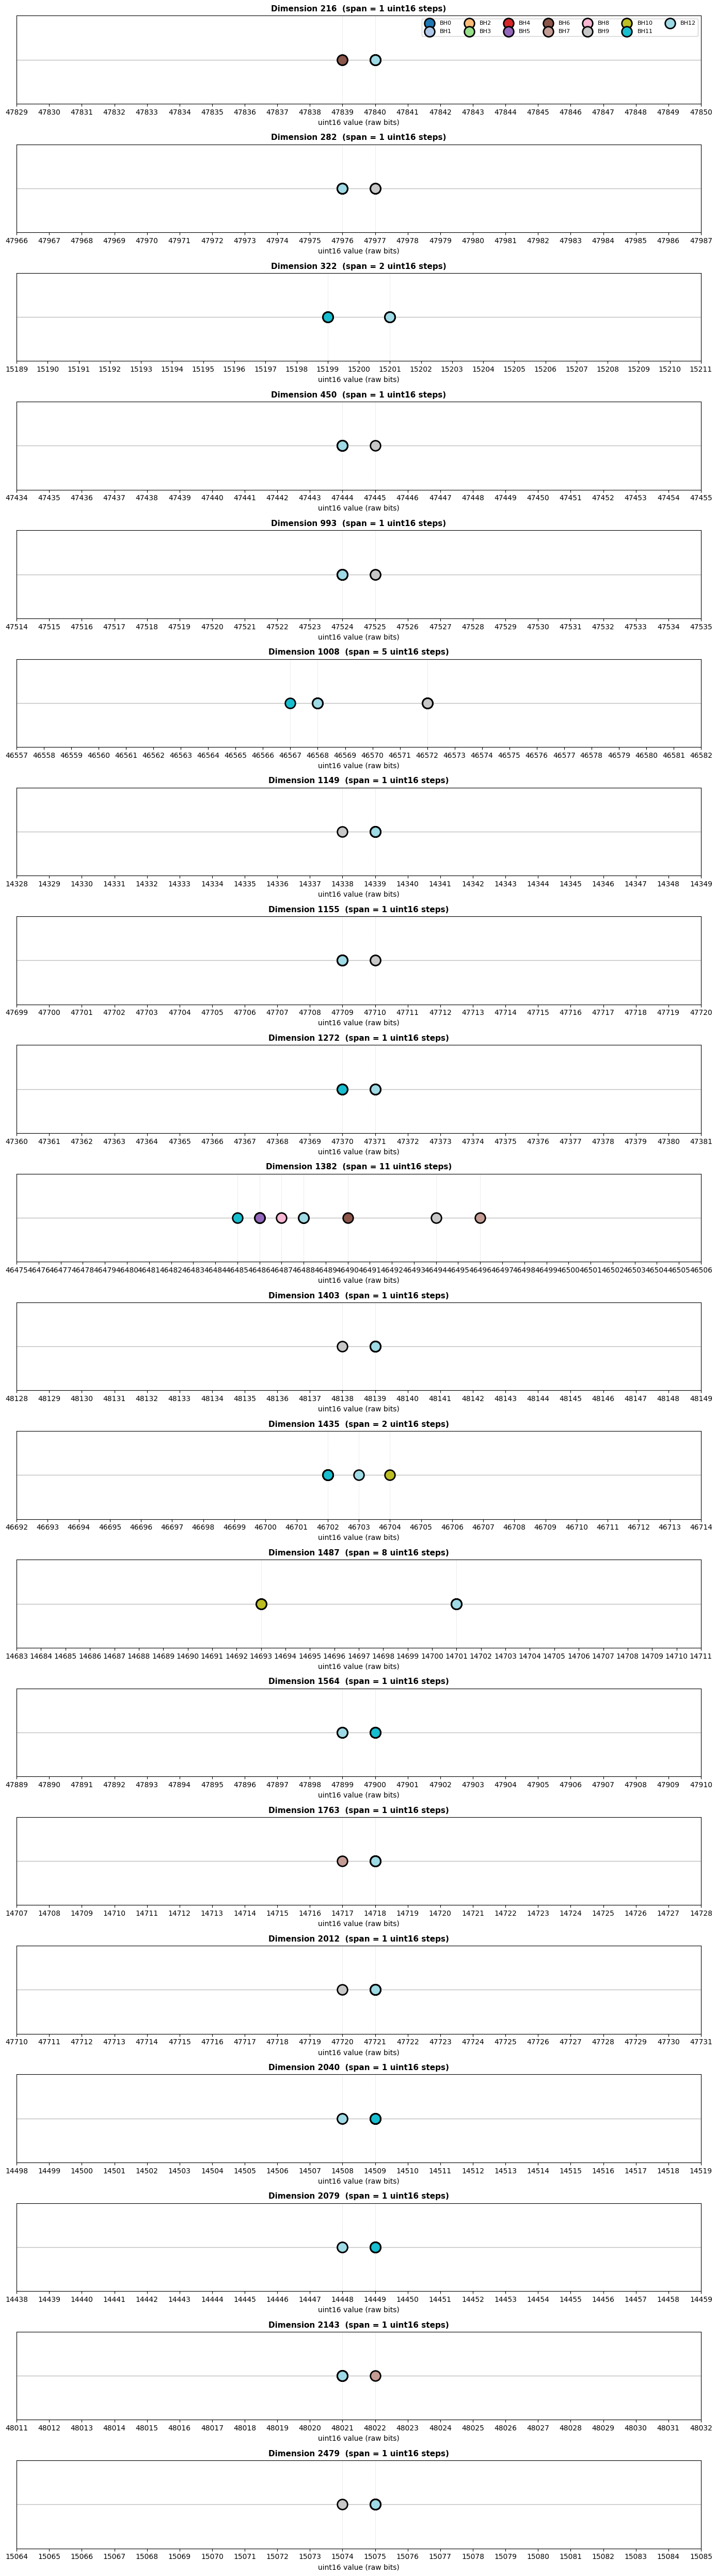

✓ Visualization complete


In [14]:
print("\nVisualizing lattice structure (first 10 dimensions)...\n")

# Create subplots for first 10 dimensions
n_dims_to_plot = min(20, len(ACTIVE_DIMS))
fig, axes = plt.subplots(n_dims_to_plot, 1, figsize=(14, 2.5 * n_dims_to_plot), dpi=100)

if n_dims_to_plot == 1:
    axes = [axes]

colors = plt.cm.tab20(np.linspace(0, 1, 13))  # 13 distinct colors

for ax_idx, dim in enumerate(ACTIVE_DIMS[:n_dims_to_plot]):
    ax = axes[ax_idx]
    
    # Extract uint16 values
    values_uint16 = [vec[dim] for vec in bh_vectors_uint16]
    
    # Plot each BH as a colored dot
    for bh_id, val_uint16 in enumerate(values_uint16):
        ax.scatter([val_uint16], [0], s=200, c=[colors[bh_id]], 
                   edgecolors='black', linewidths=2, zorder=10, label=f"BH{bh_id}")
    
    # Styling
    ax.set_yticks([])
    ax.set_xlabel('uint16 value (raw bits)', fontsize=10)
    ax.axhline(0, color='gray', linewidth=1, alpha=0.5)

    # Show tick at every integer in the range
    x_min = min(values_uint16) - padding
    x_max = max(values_uint16) + padding
    ax.set_xticks(range(int(np.floor(x_min)), int(np.ceil(x_max)) + 1))    

    # Grid at each unique value
    unique_vals = sorted(set(values_uint16))
    for val in unique_vals:
        ax.axvline(val, color='gray', linewidth=0.5, linestyle='--', alpha=0.3)
    
    # Title
    span = max(values_uint16) - min(values_uint16)
    ax.set_title(f"Dimension {dim}  (span = {span} uint16 steps)", fontsize=11, fontweight='bold')
    
    # Add padding
    if span > 0:
        padding = max(10, span * 0.2)
    else:
        padding = 10
    ax.set_xlim(min(values_uint16) - padding, max(values_uint16) + padding)
    
    # Legend only on first subplot
    if ax_idx == 0:
        ax.legend(loc='upper right', ncol=7, fontsize=8, framealpha=0.9)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## Summary: The Discrete Lattice Structure

In [15]:
print("\n" + "=" * 100)
print("SUMMARY: RAW BIT SEPARATIONS")
print("=" * 100)
print()

print("The 13 black holes sit on a discrete lattice in uint16 space.")
print()

# Collect all unique separations across all dimensions
all_separations = []
for dim in ACTIVE_DIMS:
    values_uint16 = [vec[dim] for vec in bh_vectors_uint16]
    for i in range(len(values_uint16)):
        for j in range(i+1, len(values_uint16)):
            sep = abs(int(values_uint16[i]) - int(values_uint16[j]))
            if sep > 0:
                all_separations.append(sep)

unique_all_seps = sorted(set(all_separations))

print(f"Unique uint16 separations across all {len(ACTIVE_DIMS)} active dimensions:")
print(f"  {unique_all_seps[:20]}..." if len(unique_all_seps) > 20 else f"  {unique_all_seps}")
print()

# Check if all are multiples of some base
min_sep = min(s for s in unique_all_seps if s > 0)
print(f"Minimum separation: {min_sep} uint16 steps")
print()

# Check for common factors
import math
gcd_all = unique_all_seps[0]
for sep in unique_all_seps[1:]:
    gcd_all = math.gcd(gcd_all, sep)

print(f"GCD of all separations: {gcd_all}")
print()

if gcd_all > 1:
    print(f"All separations are multiples of {gcd_all}.")
    print(f"The lattice quantum in uint16 space is {gcd_all}.")
else:
    print("Separations have GCD=1 (no common factor).")

print()
print("This confirms: the black holes occupy discrete, quantized positions")
print("in the bfloat16 representation space.")
print()
print("=" * 100)


SUMMARY: RAW BIT SEPARATIONS

The 13 black holes sit on a discrete lattice in uint16 space.

Unique uint16 separations across all 20 active dimensions:
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Minimum separation: 1 uint16 steps

GCD of all separations: 1

Separations have GCD=1 (no common factor).

This confirms: the black holes occupy discrete, quantized positions
in the bfloat16 representation space.

